In [1]:
pip install pandas numpy scikit-learn xgboost matplotlib seaborn joblib


In [2]:
import kagglehub
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix


In [3]:
dataset_path = kagglehub.dataset_download("teejmahal20/airline-passenger-satisfaction")

print("Dataset Path:", dataset_path)
print("Files:", os.listdir(dataset_path))


Using Colab cache for faster access to the 'airline-passenger-satisfaction' dataset.
Dataset Path: /kaggle/input/airline-passenger-satisfaction
Files: ['train.csv', 'test.csv']


In [4]:
train_path = os.path.join(dataset_path, "train.csv")
df = pd.read_csv(train_path)

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (103904, 25)


,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [5]:
df['satisfaction'] = df['satisfaction'].map({
    'satisfied': 1,
    'neutral or dissatisfied': 0
})

X = df.drop('satisfaction', axis=1)
y = df['satisfaction']


In [6]:
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

print("Categorical Columns:", categorical_cols)
print("Numerical Columns:", numerical_cols)


Categorical Columns: Index(['Gender', 'Customer Type', 'Type of Travel', 'Class'], dtype='object')
Numerical Columns: Index(['Unnamed: 0', 'id', 'Age', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes'],
      dtype='object')


In [7]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_cols)
])


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training size:", X_train.shape)
print("Testing size:", X_test.shape)


Training size: (83123, 24)
Testing size: (20781, 24)


In [9]:
from xgboost import XGBClassifier

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        eval_metric='logloss'
    ))
])


model.fit(X_train, y_train)
print("Model training completed.")

Model training completed.


In [10]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


In [11]:
print("Accuracy :", accuracy_score(y_test, y_pred))
print("AUC Score :", roc_auc_score(y_test, y_prob))
print("Precision :", precision_score(y_test, y_pred))
print("Recall :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("MCC Score :", matthews_corrcoef(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy : 0.9647755160964342
AUC Score : 0.9955336935398208
Precision : 0.9693634403721775
Recall : 0.9486951693503609
F1 Score : 0.958917948142328
MCC Score : 0.9282604821926334

Confusion Matrix:
[[11506   270]
 [  462  8543]]


In [12]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     11776
           1       0.97      0.95      0.96      9005

    accuracy                           0.96     20781
   macro avg       0.97      0.96      0.96     20781
weighted avg       0.96      0.96      0.96     20781



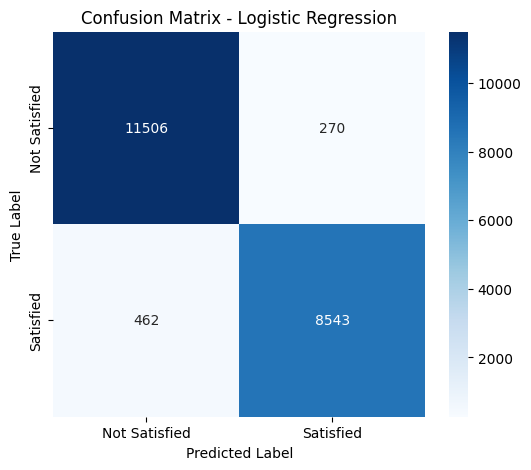

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Satisfied", "Satisfied"],
            yticklabels=["Not Satisfied", "Satisfied"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()
